In [4]:
# https://www.youtube.com/watch?v=OAKAZhFmYoI&list=PLJV_el3uVTsODxQFgzMzPLa16h6B8kWM_&index=2
# https://jizhi.im/blog/post/ppointro
# https://arxiv.org/pdf/1707.06347.pdf

import math
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from IPython.display import clear_output
from multiprocessing import Process, Pipe
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# SubprocVecEnv

In [5]:
def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close() 
    env = env_fn_wrapper()
    while True: # Trying to read the data all the day? A:Yes
        cmd, data = remote.recv()  # this remote is worker_remote
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        elif cmd == 'Message':
            print('Receive Message')
        else:
            raise NotImplementedError
        
class SubprocVecEnv(object):
    
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, env_fn))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes: 
            remote.close() # Can be shut down after the start, and close remotes in the def(function doesn't affect the self.remots in this class)
        self.remotes[0].send(('get_spaces', None))
        self.observation_space, self.action_space = self.remotes[0].recv()
        
        
    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action)) # Send the message to worker remote
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()
            
    def __len__(self):
        return self.nenvs


# Create envs

In [6]:
num_envs = 16
env_name = "Pendulum-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

# ActorCritic

In [7]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value
    
    def weight_init(self,m):
        if type(m) in [nn.Linear]:
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0.1)

In [12]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

# GAE

In [13]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    '''
    Also use GAE in PPO.
    '''
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

# PPO

In [15]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):  # Sample a batch
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
    # Can be used as an iter    
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state) # in the first iter, it hasn't been updated
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action) # use the old action to get the log_probs

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(),1)
            optimizer.step()

# Main

In [9]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4 # Collecting one time of data can be used for updating the model four times by Off-policy
threshold_reward = -200

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

max_frames = 15000
frame_idx  = 0
test_rewards = []

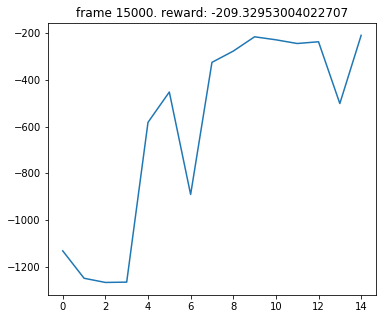

In [43]:
state = envs.reset()
early_stop = False

# off-policy, collect data once and use this data to update the model multiple times.

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)